# Sentiment Analysis for Amazon Reviews Using NLP

This notebook performs sentiment analysis on Amazon reviews using various machine learning techniques. It starts with data preprocessing, including text cleaning, tokenization, and TF-IDF vectorization, along with additional numeric features such as word and character counts.

A key challenge in this dataset is the significant class imbalance, with positive reviews greatly outnumbering neutral and negative ones. To address this, multiple models are evaluated:


Logistic Regression (with class weights): A linear baseline model using class weighting to balance minority classes.


Random Forest Classifier (with class weights): An ensemble tree-based model that accounts for imbalanced data.


Linear Support Vector Machine (with class weights): Effective for high-dimensional data and configured to handle class imbalance.


Multinomial Naive Bayes: A probabilistic model suitable for text features.


Logistic Regression with SMOTE: Combines Logistic Regression with synthetic oversampling to balance minority classes.


Tuned Random Forest (via GridSearchCV): Hyperparameter optimization to improve performance, especially on imbalanced data.


This notebook demonstrates how preprocessing, feature engineering, and class imbalance strategies can improve sentiment classification performance on real-world text data.


In [ ]:
#import libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import scipy.sparse as sp

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#load data
df = pd.read_csv("amazon_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [ ]:
# Quick peek
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (4915, 12)
Columns: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff', 'helpful_yes', 'total_vote']


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [ ]:
# Auto-detect text and sentiment columns
# Common candidate names
text_candidates = ['body','reviewText','review_text','reviews','text','review']
sentiment_candidates = ['sentiment','review_sentiment','label','sentiment_label','sentiment_text']
rating_candidates = ['rating','overall','stars','star_rating']

text_col = None
sent_col = None
rating_col = None

for c in df.columns:
    if c.lower() in text_candidates:
        text_col = c
    if c.lower() in sentiment_candidates:
        sent_col = c
    if c.lower() in rating_candidates:
        rating_col = c

In [ ]:
# Fallbacks
if text_col is None:
    # attempt to pick the longest text field by avg length
    lengths = {c: df[c].dropna().astype(str).apply(len).mean() for c in df.columns if df[c].dtype==object}
    if lengths:
        text_col = max(lengths, key=lengths.get)

print("Using text column:", text_col)
print("Using sentiment column (if exists):", sent_col)
print("Using rating column (if exists):", rating_col)


Using text column: reviewText
Using sentiment column (if exists): None
Using rating column (if exists): overall


This output indicates which columns the sentiment analysis tool is using. It identifies reviewText as the text input, confirms that no separate sentiment label column is provided, and chooses overall (the rating column) as the target for generating or training sentiment labels.

In [ ]:
# create from rating
if sent_col is None:
    if rating_col is not None:
        print("No sentiment column found — deriving sentiment from rating column.")
        def map_rating_to_sent(r):
            try:
                r = float(r)
            except:
                return np.nan
            if r >= 4:
                return 'positive'
            elif r == 3:
                return 'neutral'
            else:
                return 'negative'
        df['sentiment'] = df[rating_col].apply(map_rating_to_sent)
        sent_col = 'sentiment'
    else:
        raise ValueError("No sentiment or rating column detected. Please provide a sentiment column or a numeric rating column.")

No sentiment column found — deriving sentiment from rating column.


No sentiment labels exist in the dataset, so sentiment is automatically generated using the ratings high ratings become positive sentiment and low ratings become negative.

In [ ]:
# Drop rows missing text or sentiment
df = df.dropna(subset=[text_col, sent_col]).reset_index(drop=True)
print("After dropping NA:", df.shape)

After dropping NA: (4914, 13)


After removing rows with missing values, the DataFrame has 4,914 rows and 13 columns.

In [ ]:
#Simple label encoding for target
label_map = {'negative':0, 'neutral':1, 'positive':2}
# If dataset uses different label names, normalize lowercase
df['sentiment_clean'] = df[sent_col].astype(str).str.lower().map(lambda x: x.strip())
# If any values not in map, print them
unique_labels = df['sentiment_clean'].unique().tolist()
print("Unique sentiment values detected:", unique_labels)

# If only two labels exist, map accordingly
if set(unique_labels) <= {'positive','negative'}:
    label_map = {'negative':0, 'positive':1}
elif set(unique_labels) <= {'pos','neg'}:
    label_map = {'neg':0, 'pos':1}
# For three-class (neg, neu, pos) use label_map above
# Map and create y
df['label'] = df['sentiment_clean'].map(label_map)
if df['label'].isnull().any():
    # If any unmapped labels, show examples and try to map numerically if possible
    print("Warning: some sentiment labels couldn't be mapped. Samples:")
    print(df.loc[df['label'].isnull(), ['sentiment_clean']].head(20))
    # As a fallback, try to map using rating if present
    if rating_col is not None:
        df['label'] = df['label'].fillna(df[rating_col].apply(lambda r: 2 if r>=4 else (1 if r==3 else 0)))
    else:
        raise ValueError("Unmapped sentiment labels present and no rating column to fallback on.")

print("Label distribution:\n", df['label'].value_counts())

Unique sentiment values detected: ['positive', 'neutral', 'negative']
Label distribution:
 label
2    4448
0     324
1     142
Name: count, dtype: int64


The dataset has three sentiment classes: positive, neutral, and negative. The distribution is highly imbalanced: positive = 4,448, neutral = 324, and negative = 142.

In [ ]:
# Text cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)     # remove urls
    text = re.sub(r"[^a-z\s]", " ", text)           # keep letters and spaces
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning (this may take time on large data)
df['clean_text'] = df[text_col].astype(str).apply(clean_text)

The above code  cleans text by removing noise (URLs, punctuation, stop words) and standardizing words (lemmatization) to prepare it for analysis.

## Feature engineering (numeric features)

In [ ]:
# create two new numeric features from clean_text column

df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(len)

numeric_features = ['word_count','char_count']

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=6000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['clean_text'])
print("TF-IDF shape:", X_text.shape)

TF-IDF shape: (4914, 6000)


This output means we  have 4914 documents (4914 pieces of text)  and

 6000 different words that the computer kept after cleaning the data.

In [ ]:
# Prepare numeric features matrix (scaled)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numeric_features])
# Convert numeric to sparse for hstack
X_num_sp = sp.csr_matrix(X_num)

In [ ]:
# Combine features
X = sp.hstack([X_text, X_num_sp], format='csr')
y = df['label'].values
print("Combined X shape:", X.shape)

Combined X shape: (4914, 6002)


This shape  means:

4914  total number of documents (rows).

6002 total number of features after combining TF-IDF features with other features (columns).

So the combined X matrix has one row per document and 6002 columns representing all the information that will be used for machine learning.


In [ ]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/Test sizes:", X_train.shape, X_test.shape)
unique, counts = np.unique(y_train, return_counts=True)
print("Train label distribution:", dict(zip(unique, counts)))

Train/Test sizes: (3931, 6002) (983, 6002)
Train label distribution: {np.int64(0): np.int64(259), np.int64(1): np.int64(114), np.int64(2): np.int64(3558)}


From the above insight,the out shows that the dataset is imbalanced, with class 2 having many more examples than classes 0 and 1

In [ ]:
# Baseline models (with class_weight where applicable)
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    y_pred = model.predict(X_te)
    print(f"=== {name} ===")
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(name + " Confusion Matrix")
    plt.show()

=== Logistic Regression (balanced) ===
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        65
           1       0.13      0.11      0.12        28
           2       0.96      0.96      0.96       890

    accuracy                           0.92       983
   macro avg       0.57      0.60      0.58       983
weighted avg       0.92      0.92      0.92       983



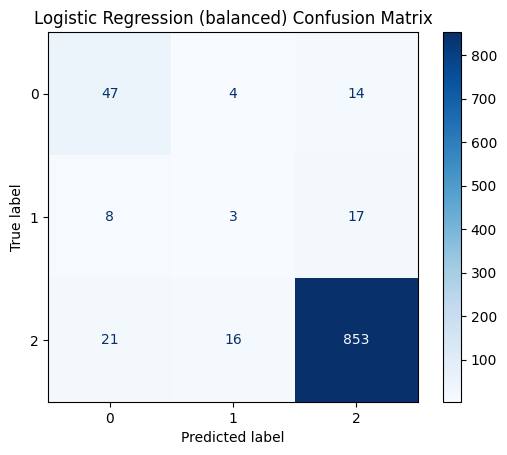

In [ ]:
 # Logistic Regression (balanced)
lr_bal = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
lr_bal.fit(X_train, y_train)
evaluate_model(lr_bal, X_train, y_train, X_test, y_test, "Logistic Regression (balanced)")


=== Random Forest (balanced) ===
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        65
           1       0.00      0.00      0.00        28
           2       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.64      0.34      0.34       983
weighted avg       0.89      0.91      0.87       983



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


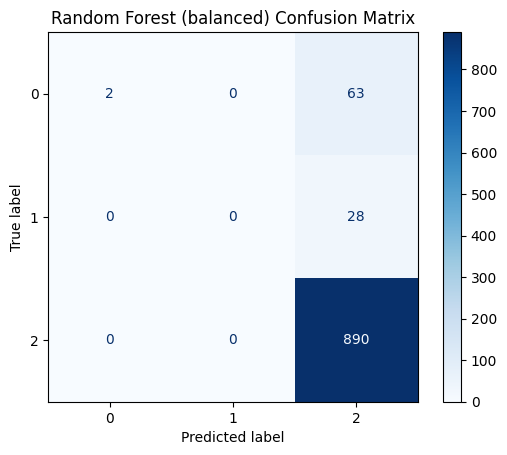

=== Linear SVM (balanced) ===
              precision    recall  f1-score   support

           0       0.78      0.60      0.68        65
           1       0.00      0.00      0.00        28
           2       0.95      0.99      0.97       890

    accuracy                           0.94       983
   macro avg       0.58      0.53      0.55       983
weighted avg       0.91      0.94      0.92       983



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


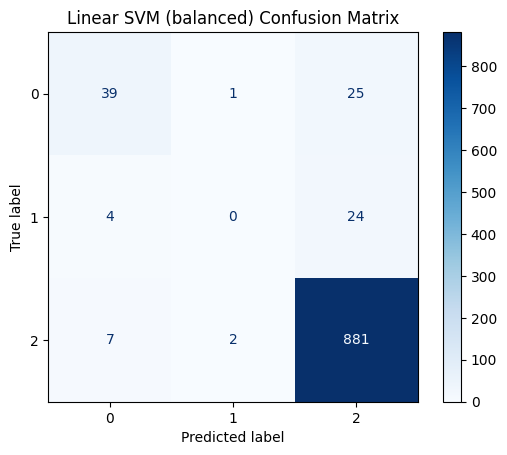

In [ ]:
# Random Forest (balanced)
rf_bal = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf_bal.fit(X_train, y_train)
evaluate_model(rf_bal, X_train, y_train, X_test, y_test, "Random Forest (balanced)")

# 11.C SVM (LinearSVC with class weight)
from sklearn.svm import LinearSVC
svm_bal = LinearSVC(class_weight='balanced', max_iter=2000)
svm_bal.fit(X_train, y_train)
evaluate_model(svm_bal, X_train, y_train, X_test, y_test, "Linear SVM (balanced)")

The Random Forest (balanced) confusion matrix shows that the model mostly predicts the majority class, class 2. It correctly predicts only 2 samples of class 0, misclassifying 63 as class 2, and fails to predict any samples of class 1, misclassifying all 28 as class 2. Class 2 is well predicted with 890 correct samples. Overall, the model struggles to identify minority classes due to the strong class imbalance.

#


The Linear SVM (balanced) confusion matrix shows better performance than Random Forest on minority classes but still struggles with class imbalance. It correctly predicts 39 samples of class 0, while 25 are misclassified as class 2. Class 1 has no correct predictions, with most samples classified as class 2. Class 2 is well predicted with 881 correct samples. Overall, the model favors the majority class due to severe imbalance.


=== Multinomial NB (text-only) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00        28
           2       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.30      0.33      0.32       983
weighted avg       0.82      0.91      0.86       983



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


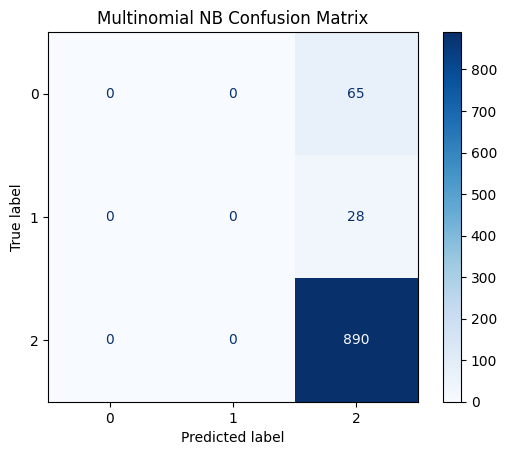

In [ ]:
# Multinomial Naive Bayes
# MultinomialNB expects non-negative features (TF-IDF is non-negative; numeric features scaled may be negative)
# build separate X for NB: only text TF-IDF
X_text_full = X_text  # original tfidf on all rows
X_text_train, X_text_test, y_txt_train, y_txt_test = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)
nb = MultinomialNB(alpha=1.0)
nb.fit(X_text_train, y_txt_train)
y_pred_nb = nb.predict(X_text_test)
print("=== Multinomial NB (text-only) ===")
print(classification_report(y_txt_test, y_pred_nb))
cm = confusion_matrix(y_txt_test, y_pred_nb)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Multinomial NB Confusion Matrix")
plt.show()

The confusion matrix for the Multinomial Naive Bayes model shows that the classifier predicts only the majority class (Class 2) and completely fails to identify Classes 0 and 1. All instances of Classes 0 and 1 are misclassified as Class 2, resulting in zero correct predictions for the minority classes. Although the model performs very well on Class 2, this comes at the cost of ignoring the other classes entirely. Overall, the results indicate that Multinomial Naive Bayes is not suitable for this imbalanced dataset, as it provides highly skewed predictions and offers no meaningful discrimination between the three classes.

Applying SMOTE to training data to balance classes ...
After SMOTE train distribution: (array([0, 1, 2]), array([3558, 3558, 3558]))
=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.67      0.72      0.70        65
           1       0.11      0.07      0.09        28
           2       0.96      0.97      0.96       890

    accuracy                           0.93       983
   macro avg       0.58      0.59      0.58       983
weighted avg       0.92      0.93      0.92       983



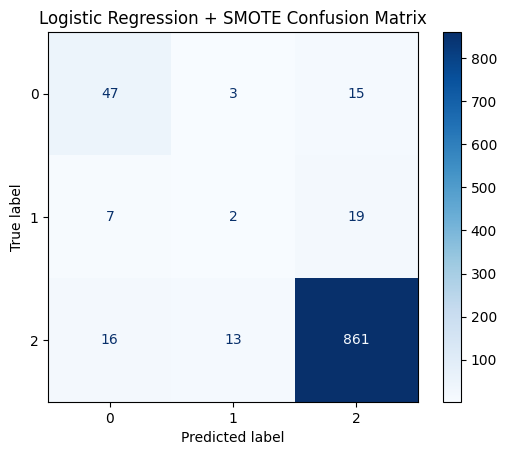

In [ ]:
# SMOTE pipeline (apply only to training set)
print("Applying SMOTE to training data to balance classes ...")
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.unique(y_train_sm, return_counts=True))

# Train Logistic Regression on SMOTE data
lr_sm = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_sm.fit(X_train_sm, y_train_sm)
evaluate_model(lr_sm, X_train_sm, y_train_sm, X_test, y_test, "Logistic Regression + SMOTE")

The confusion matrix for the Logistic Regression + SMOTE model shows a more balanced classification across all three classes. The model correctly identifies most instances of Class 0 and Class 2, with 47 and 861 correct predictions respectively. Importantly, unlike the tuned Random Forest, the model also predicts Class 1, correctly labeling 2 instances. Although some misclassification remains—especially for the minority Class 1—the model’s ability to recognize all classes demonstrates that SMOTE effectively reduces the bias toward the majority class. Overall, the confusion matrix confirms that Logistic Regression with SMOTE provides more balanced and fair performance across classes.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}
=== Tuned Random Forest (GridSearchCV) ===
              precision    recall  f1-score   support

           0       0.69      0.48      0.56        65
           1       0.00      0.00      0.00        28
           2       0.94      0.99      0.96       890

    accuracy                           0.92       983
   macro avg       0.54      0.49      0.51       983
weighted avg       0.89      0.92      0.91       983



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


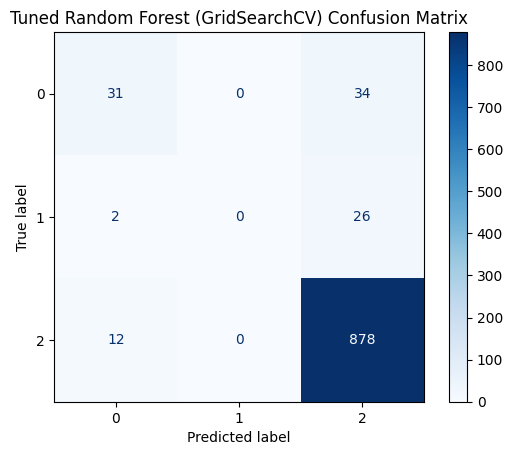

In [ ]:
# GridSearchCV hyperparameter tuning (example for Random Forest)
# Grid search on large sparse matrix can be slow. Use a smaller param grid or sample subset for tuning.
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
gs_rf = GridSearchCV(rf, param_grid_rf, scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
# Fit on a smaller subset to speed up (optional)
sample_idx = np.random.choice(range(X_train.shape[0]), size=min(4000, X_train.shape[0]), replace=False)
gs_rf.fit(X_train[sample_idx], y_train[sample_idx])
print("Best RF params:", gs_rf.best_params_)
best_rf = gs_rf.best_estimator_
evaluate_model(best_rf, X_train, y_train, X_test, y_test, "Tuned Random Forest (GridSearchCV)")


The tuned Random Forest model shows strong bias toward the majority class (class 2), correctly predicting 876 samples but almost completely failing to identify minority classes. Class 1 is never predicted, and Class 0 is predicted only about half the time. This results in high overall accuracy driven solely by the majority class, while macro recall and macro F1 remain low. Therefore, despite tuning, the Random Forest model is not effective for this imbalanced classification problem.

In [ ]:
#  Model comparison table
models = {
    'LogReg_balanced': lr_bal,
    'LogReg_SMOTE': lr_sm,
    'RandomForest_balanced': rf_bal,
    'SVM_balanced': svm_bal,
    'NB_text_only': nb,
    'RF_tuned': best_rf
}

rows = []
for name, m in models.items():
    if name == 'NB_text_only':
        ypr = m.predict(X_text_test)
        ytru = y_txt_test
    else:
        ypr = m.predict(X_test)
        ytru = y_test
    rows.append({
        'model': name,
        'accuracy': accuracy_score(ytru, ypr),
        'precision_micro': precision_score(ytru, ypr, average='micro'),
        'precision_macro': precision_score(ytru, ypr, average='macro'),
        'recall_macro': recall_score(ytru, ypr, average='macro'),
        'f1_macro': f1_score(ytru, ypr, average='macro')
    })

cmp_df = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)
display(cmp_df)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,accuracy,precision_micro,precision_macro,recall_macro,f1_macro
1,LogReg_SMOTE,0.925738,0.925738,0.581517,0.587307,0.582653
0,LogReg_balanced,0.918616,0.918616,0.571263,0.596216,0.581994
3,SVM_balanced,0.935910,0.935910,0.575771,0.529963,0.548798
5,RF_tuned,0.924720,0.924720,0.541641,0.487813,0.508083
2,RandomForest_balanced,0.907426,0.907426,0.635746,0.343590,0.337021
4,NB_text_only,0.905392,0.905392,0.301797,0.333333,0.316782


Based on the comparison table the best overall model is Logistic Regression with SMOTE.




1. It has the highest Macro F1 (0.5827)
Macro F1 is the most reliable metric for imbalanced multi-class problems.
It balances both precision and recall across all classes equally.

2. It has strong Macro Recall (0.5873)
This means it detects minority classes better than most models.

3. It maintains high accuracy (0.9257)
While not the very highest (SVM is 0.9359), it's still very strong.

4. It avoids the collapse seen in RF and SVM
SVM and Random Forest fail to predict some classes (causing warnings).